<a href="https://colab.research.google.com/github/CHERR4/TFM-Crypto-Predict/blob/master/TFM_Predicting_Crypto_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.8.1

  Cloning https://github.com/JoaquinAmatRodrigo/skforecast (to revision v0.1.8.1) to /tmp/pip-req-build-5tgpxr5i
  Running command git clone -q https://github.com/JoaquinAmatRodrigo/skforecast /tmp/pip-req-build-5tgpxr5i
  Running command git checkout -q e9f125fec47e13a6ba768bf9e5c362815e84d767
  Created wheel for skforecast: filename=skforecast-0.1.8.1-cp37-none-any.whl size=25669 sha256=58e25a75a0992df76bd1e6ab64a0fbf40b883623cd4d3270cdb45763377f83ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-nv1lpgnq/wheels/6e/35/85/7ac8338095a8a31e1d870230c04f48fc9f0a2c76d5130ecaf9
Successfully built skforecast


In [2]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
import time
import math

In [4]:
csv_path = "https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1626048000&interval=1d&events=history&includeAdjustedClose=true"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [5]:
df.shape

(2491, 7)

## Data processing

In [6]:
colnames = {
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Adj Close': 'adjClose',
    'Volume': 'volume'
}
df.rename(columns = colnames, inplace=True)
df.head()

,date,open,high,low,close,adjClose,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [7]:
df.isna().sum()

date        0
open        4
high        4
low         4
close       4
adjClose    4
volume      4
dtype: int64

In [8]:
df.fillna(method="ffill", inplace=True)
df.isna().sum()

date        0
open        0
high        0
low         0
close       0
adjClose    0
volume      0
dtype: int64

In [9]:
df['close']

0         457.334015
1         424.440002
2         394.795990
3         408.903992
4         398.821014
            ...     
2486    32877.371094
2487    33798.011719
2488    33520.519531
2489    34240.187500
2490    33155.847656
Name: close, Length: 2491, dtype: float64

## Feature selection

In [10]:
df.dtypes

date        datetime64[ns]
open               float64
high               float64
low                float64
close              float64
adjClose           float64
volume             float64
dtype: object

In [11]:
close_df = df[['date', 'close']]
close_df.set_index('date', inplace=True)
close_df.head()

,close
date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [24]:
close_ts = pd.Series(close_df['close'], index= df['date'])
close_ts

date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2021-07-08    32877.371094
2021-07-09    33798.011719
2021-07-10    33520.519531
2021-07-11    34240.187500
2021-07-12    33155.847656
Name: close, Length: 2491, dtype: float64

## Dataset as timeseries

In [12]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(8,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

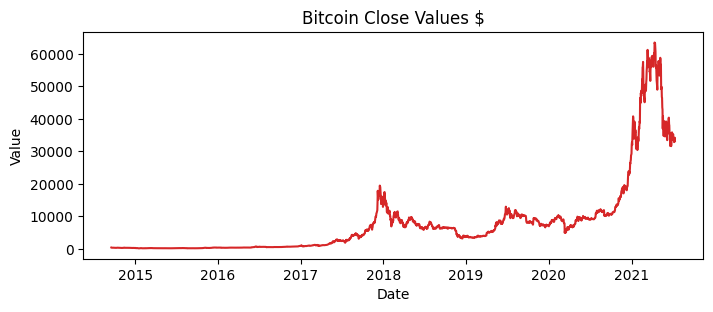

In [13]:
plot_df(close_df, x=close_df.index, y=close_df.close, title='Bitcoin Close Values $')    

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


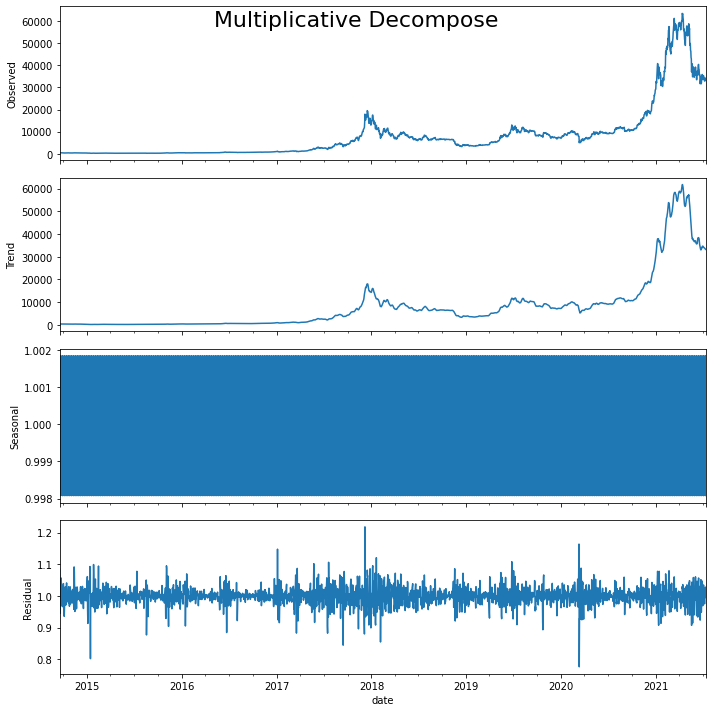

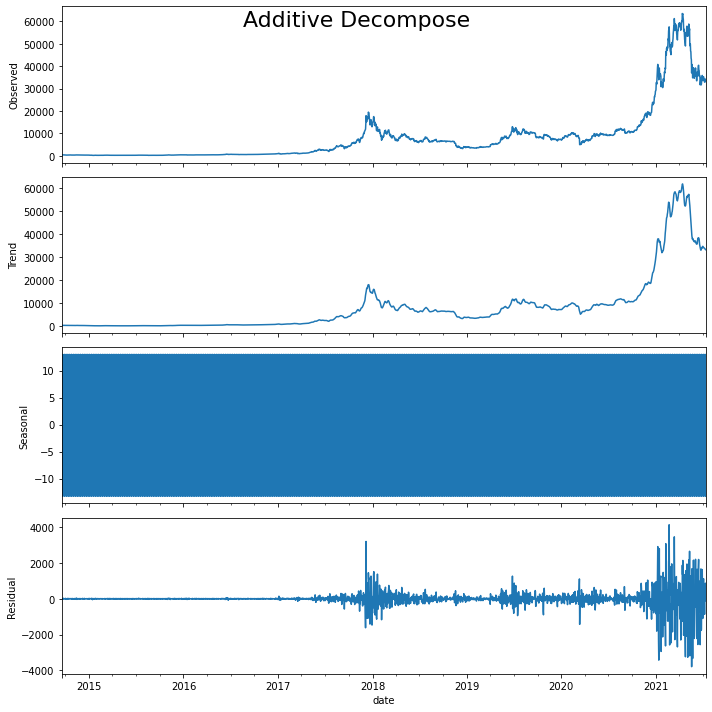

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative decomponse
multiplicative_decompose = seasonal_decompose(close_df['close'], model='multiplicative', extrapolate_trend='freq')

# Additive decompose
additive_decompose = seasonal_decompose(close_df['close'], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
multiplicative_decompose.plot().suptitle('Multiplicative Decompose', fontsize=22)
additive_decompose.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

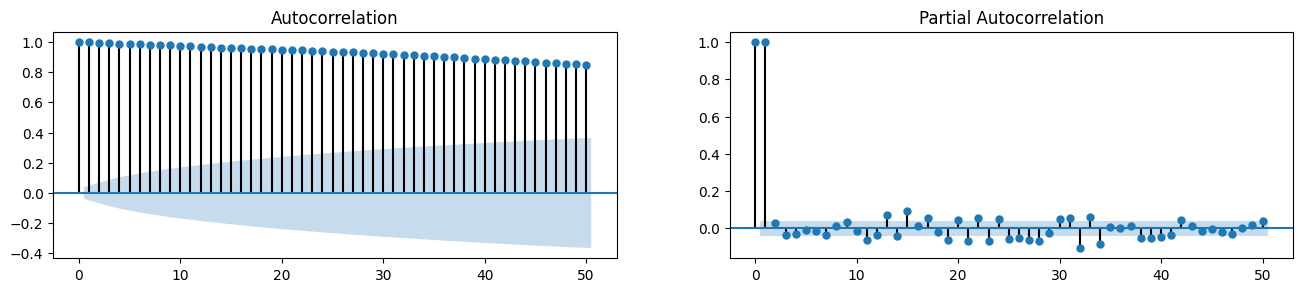

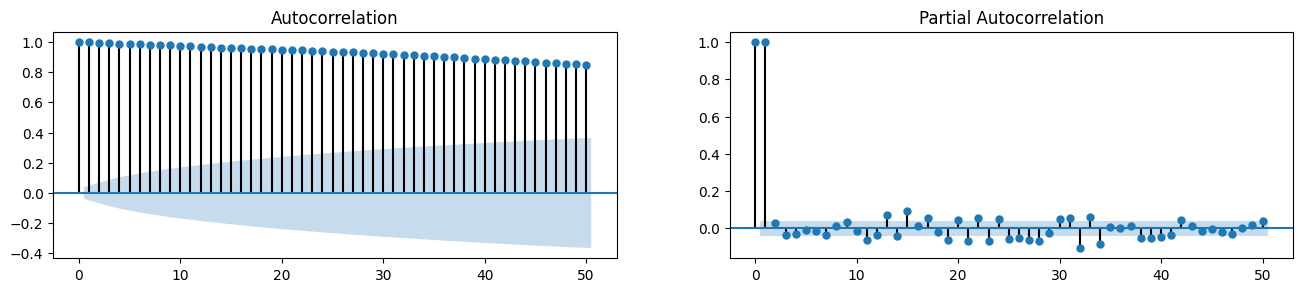

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(close_df.close.tolist(), lags=50, ax=axes[0])
plot_pacf(close_df.close.tolist(), lags=50, ax=axes[1])

# Smoothing

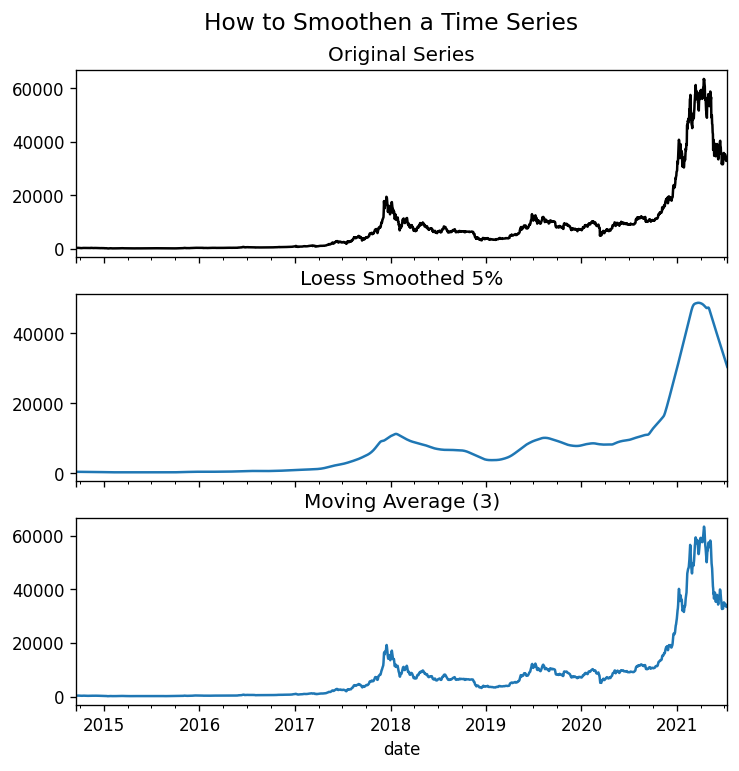

In [16]:
from statsmodels.nonparametric.smoothers_lowess import lowess

df_loess_5 = pd.DataFrame(lowess(close_df.close, np.arange(len(close_df.close)), frac=0.05)[:, 1], index=close_df.index, columns=['close'])
df_ma = close_df.close.rolling(3, center=True, closed='both').mean()

fig, axes = plt.subplots(3,1, figsize=(7, 7), sharex=True, dpi=120)
close_df['close'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['close'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_ma.plot(ax=axes[2], title='Moving Average (3)')

fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

## Train/Test split

In [48]:
N_TEST = 3
train_ts = close_ts[:-N_TEST]
train_ts.shape

(2488,)

In [49]:
test_ts = close_ts[-N_TEST:]
test_ts.shape

(3,)

In [52]:
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor


forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags=15)

forecaster_rf.fit(y=train_ts)
forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=123)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

## Predict

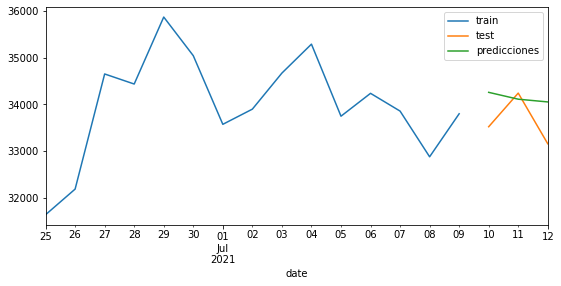

In [53]:
predictions = forecaster_rf.predict(steps=N_TEST)
predictions_ts = pd.Series(data=predictions, index=test_df.index)

train_plot_df = train_ts[-15:]
# Plot
fig, ax = plt.subplots(figsize=(9, 4))
train_plot_df.plot(ax=ax, label='train')
test_ts.plot(ax=ax, label='test')
predictions_ts.plot(ax=ax, label='predicciones')
ax.legend();

In [110]:
predictions_df = pd.DataFrame(predictions_ts)
predictions_df.reset_index(inplace=True)
predictions_df['row_different_0'] = predictions_df.apply(lambda row: row.name > 0, axis=1)
predictions_df['row_going_up'] = predictions_df.apply(lambda row: row.name > 0 and predictions_df.loc[row.name-1, :][0] < row[0], axis=1)
predictions_df.head()

,date,0,row_different_0,row_going_up
0,2021-07-10,34256.414766,False,False
1,2021-07-11,34109.969063,True,False
2,2021-07-12,34051.245274,True,False


## Evaluate

In [90]:
from sklearn.metrics import mean_squared_error

def evaluate(model, ts, n_evaluations, n_test):
  total_error = 0
  for i in range(1, n_evaluations + 1):
    print('Iteration', i, 'started')
    train_evaluate = ts[:-n_test*i]
    test_evaluate = ts[-n_test*i:]
    test_evaluate = test_evaluate[:n_test]
    model.fit(y=train_evaluate)
    predictions = model.predict(steps=n_test)
    predictions_ts = pd.Series(data=predictions, index=test_evaluate.index)

    error_mse = mean_squared_error(
                y_true = test_evaluate,
                y_pred = predictions_ts
            )
    total_error += error_mse
    print('Iteration:', i, 'error:', error_mse, 'total error:', total_error)
  print('Mean error by evaluation:', total_error / n_evaluations)
  print('Mean error by element predicted:', total_error / (n_evaluations * n_test))
  return total_error

In [91]:
N_EVALUATIONS = 10

evaluate(forecaster_rf, close_ts, N_EVALUATIONS, N_TEST)

Iteration 1 started
Iteration: 1 error: 453411.8438897945 total error: 453411.8438897945
Iteration 2 started
Iteration: 2 error: 3337658.9773119353 total error: 3791070.8212017296
Iteration 3 started
Iteration: 3 error: 1632773.9561742842 total error: 5423844.777376014
Iteration 4 started
Iteration: 4 error: 3416143.2016248903 total error: 8839987.979000904
Iteration 5 started
Iteration: 5 error: 2246013.234933772 total error: 11086001.213934675
Iteration 6 started
Iteration: 6 error: 10331845.63275355 total error: 21417846.846688226
Iteration 7 started
Iteration: 7 error: 870447.716406538 total error: 22288294.563094765
Iteration 8 started
Iteration: 8 error: 7556378.850575638 total error: 29844673.413670402
Iteration 9 started
Iteration: 9 error: 2560189.520444203 total error: 32404862.934114605
Iteration 10 started
Iteration: 10 error: 22574753.888416618 total error: 54979616.82253122
Mean error by evaluation: 5497961.682253122
Mean error by element predicted: 1832653.8940843742


54979616.82253122